# 05-Surface Photometry

References:
* [Jedrzejewski 1987](https://academic.oup.com/mnras/article/226/4/747/1003560)
* [Ciambur et al. 2015 (ISOFIT)](https://iopscience.iop.org/article/10.1088/0004-637X/810/2/120/meta)
* [Peng et al. 2010 (GALFIT)](https://iopscience.iop.org/article/10.1088/0004-6256/139/6/2097)


* [SNU_AOclass Notebook - Extended Sources](https://github.com/ysBach/SNU_AOclass/blob/master/Notebooks/06-Extended_Sources.ipynb)


* [`photutils.isofit` Documentation](https://photutils.readthedocs.io/en/stable/isophote.html)
* [Elliptical Isophote Analysis](https://photutils.readthedocs.io/en/stable/isophote.html)
* [API for EllipseGeometry](https://photutils.readthedocs.io/en/stable/api/photutils.isophote.EllipseGeometry.html)
* [API for Ellipse](https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Ellipse.html)


<div class="alert alert-block alert-warning">
이 노트북이 메모리를 많이 차지하는 것을 확인했습니다 (약 2GB 정도). 왜 그런지는 조금 더 들여다 봐야할 것 같은데 직접 사용할  일이 없으신 분들은 과정만 봐 주셔도 되고 굳이 실행할 필요는 없습니다.
</div>

## Photometry for extended sources

* Extended sources : Galaxies, star clusters, nebulae, gas, ...


* Surface photometry (photons/area)
    - Structureal parameters, SB(r), SB(x,y), integrated mag(<r)
   
* Aperture photometry
    - Elliptical annual aperture, polygon aperture

* Ellipse (model) fitting photometry
    - Fitting isophotes with ellipses


## Ellipse fitting

타원 피팅을 하기 위해 표면 밝기를 다음과 같이 푸리에 급수로 모델링

$$I(\phi) = \langle I_{\rm ell}\rangle + \sum_n[A_n \sin(n\phi) + B_n \cos (n\phi)]$$

* $I(\phi)$: the intensity profile along the isophote, expressed as a function of (central) azimuthal angle
* $\langle I_{\rm ell}\rangle$: the average intensity of the purely elliptical path
* $\sum_n[...]$: Fourier harmonic perturbations to $\langle I_{\rm ell}\rangle$


각 계수는 다음과 같은 의미를 가진다.
![](./figs/ell.png)
Ref. [Ciambur et al. 2015 (ISOFIT)](https://iopscience.iop.org/article/10.1088/0004-637X/810/2/120/meta).

빨간색은 음수, 파란색은 양수일 때이다.


은하의 이미지를 타원형으로 피팅하기 위해서 다음과 같은 과정을 거친다.
* 먼저 초기값으로 넣어준 타원의 장축 위에 elliptical isophote를 피팅할 위치를 여러개 지정
* 지정된 여러개의 위치에서 초기값(중심 좌표 $(x_0, y_0)$, PA, $e$)을 이용한 타원을 가정
* 이 타원 위에서 $I_{\rm data}(\phi)$를 1D로 샘플링
* 위 그림에서 $n=1,2$는 타원의 타원율(ellipticity, $e=1-b/a$)과 위치각(position angle, PA)을 변화시키기 때문에 다음과 같이 $n$을 $n \in \{1,2\}$으로 제한하여 모델링

$$I(\phi) = \langle I_{\rm ell}\rangle + \sum_{n=1}^{2}[A_n \sin(n\phi) + B_n \cos (n\phi)]$$

* Least-square minimization of the quantity $S$

$$S = \sum_i [I_{\rm data}(\phi_i)-I(\phi_i)]^2$$

* 위와 같이 처음 두 개의 조화 계수를 이용해서 장축에 대한 pure elliptical isophotes를 결정
* 결정된 타원들을 가지고 $n \geq 3$의 조화 계수들을 다시 피팅


위의 알고리즘은 [Jedrzejewski 1987](https://academic.oup.com/mnras/article/226/4/747/1003560)를 따른 것이고, IRAF/Isophot/ellipse에 구현되어있어 이것이 널리 사용되었다. 이 노트에서는 동일한 알고리즘을 따르는 파이썬의 `photutils.isophote.ellipse`를 이용해서 타원은하 M89의 표면밝기를 타원 피팅을 이용해 측광할 것이다.


## SDSS image

이 노트에서 사용할 이미지는 SDSS의 이미지 데이터에서 가져온 것이다. SDSS에서 제공하는 이미지는 nanomaggy단위로 이미 표준화된 이미지이다. 따라서 표준화가 되지 않은 이미지로 측광을 할 때에는 이미지에 있는 표준화된 별의 등급을 사용해야한다. SDSS의 플럭스와 등급 체계는 [SDSS Measures Fluxes and Magnitudes](https://www.sdss.org/dr17/algorithms/magnitudes/)에 정리되어 있다. SDSS에서 사용하는 단위인 1 maggy는 AB등급체계에서 사용하는 기준과 같은 3631 Jy이며, 이는 모든 밴드에서 동일하게 적용된다. 만약 $f$가 nanomaggy의 단위를 가질 경우 SDSS의 등급은 다음과 같이 계산할 수 있으며, 이는 AB등급과 몇 퍼센트 이내의 차이를 보이는 것으로 알려져 있다.

$$m = -2.5\log(f/f_0) = 2.5 \times 9 -2.5\log(f) = 22.5 -2.5\log (f)$$

SDSS 이미지는 [SDSS Science Archive Server - Imaging Mosaics](https://dr12.sdss.org/mosaics)에서 위치와 이미지의 크기 등을 입력하면 해당 위치와 겹치는 모든 이미지를 받을 수 있고, 이를 `Swarp` 프로그램을 이용하여 합치면 얻을 수 있다. 자세한 내용은 해당 링크에 설명이 되어있고, 여기에서는 이미 받아놓은 이미지를 사용할 것이다. 

## Notebook Setup

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, ccdproc, photutils, ysfitsutilpy, ysphotutilpy, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2022-05-11 22:42:54 (GMT+0900) 
0 Python     3.9.12 64bit [Clang 12.0.0 ]
1 IPython    7.31.1
2 OS         macOS 10.16 x86_64 i386 64bit
3 astropy    5.0.4
4 numpy      1.21.2
5 scipy      1.7.3
6 matplotlib 3.5.1
7 astroquery 0.4.7.dev7672
8 ccdproc    2.3.0
9 photutils  1.4.0
10 ysfitsutilpy 0.2.dev0
11 ysphotutilpy 0.0.2.dev0
12 version_information 1.0.4


## Importing Packages

In [2]:
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import SigmaClip
from astroquery.sdss import SDSS

from matplotlib import pyplot as plt
from matplotlib import rcParams

from photutils.isophote import EllipseGeometry, Ellipse
from photutils.isophote import build_ellipse_model
from photutils.aperture import SkyCircularAperture as SCAp
from photutils.aperture import SkyCircularAnnulus as SCAn
from photutils.aperture import aperture_photometry, ApertureStats

from scipy.optimize import curve_fit

rcParams.update({'font.size':12})

## Path Setup

In [3]:
DATADIR = Path('../data/example')
NAME = 'M89'
imglist = list(DATADIR.glob('m89_[gr].fits'))
imglist.sort()
print(imglist)

interval = ZScaleInterval() # for zscale image plot

[PosixPath('../data/example/m89_g.fits'), PosixPath('../data/example/m89_r.fits')]


## Define Functions and Class

다음은 타원 피팅으로 표면 밝기를 측광하는데 필요한 코드를 모아 클래스로 만든 것이다. 각 단계에서 어떤 함수가 사용되는지 살펴보면 도움이 될 것이다. 단계마다 어떤 계산이 이루어지는지 보기는 불편할 수 있지만, 클래스를 활용하여 추후에 다른 이미지에도 적용하기 편리하도록 코드를 구성하는 방법도 있음을 보여주고자 이러한 방식을 택하였다. 다만 부족함이 많은 코드이니 참고만 할 것.


In [23]:
# Sersic law (magnitude)
def sersic(r, mu_eff, r_eff, n):
    bn = 2 * n - 1/3
    return mu_eff + (2.5 * bn / np.log(10)) * ((r / r_eff)**(1/n) - 1)


# Sersic law (flux)
def sersic_flux(r, Ie, re, n):
    return Ie*np.exp(-(2*n-1/3)*((r/re)**(1./n)-1))


# Double components of Sersic law (mag)
def double_sersic(r, Ie1, re1, n1, Ie2, re2, n2):
    I = sersic_flux(r, Ie1, re1, n1) + sersic_flux(r, Ie2, re2, n2)
    return 22.5 - 2.5*np.log10(I)  # SDSS zero-point; you may have to change it 


class SloanGalaxySurfacePhot:
    def __init__(self, imgpath, sky_r0, pixel_scale, name='',
                 band='', mag0=22.5):
        '''
        This class loads SDSS fits file of an image of a galaxy, queries stars
        in the field, does aperture photometry for these stars to obtain FWHM
        of the PSF, fit elliptical isophote to this galaxy, and carries out
        surface photometry.

        Parameters
        ----------
        imgpath : pathlib Path
            Path of subject SDSS fits image
        sky_r0 : int
            The outer boundary for sky estimation in pixel
        pixel_scale : float
            pixel scale in arcsec
        name : str, optional
            The name of the target in the input image. The default is ''.
        band : str, optional
            The filter used for the input image. The default is ''.
        mag0 : float, optional
            The zero-point for calculating magnitudes. The default is 22.5,
            which is the standard for the calibrated SDSS images.

        Returns
        -------
        None.

        '''
        self.imgpath = imgpath
        self.sky_r0 = sky_r0
        self.pixel_scale = pixel_scale
        self.mag0 = mag0
        self.name = name
        self.band = band
        
    def set_image(self, ext=0, display=True, vmax=0.7):
        self.img, self.hdr = fits.getdata(self.imgpath, header=True, ext=ext)
        self.wcs = WCS(self.hdr)
        self.x_center, self.y_center = np.array(self.img.shape)/2
        
        r0 = self.sky_r0   # outer boundary for sky estimation

        # --- Background estimation for determining backgroun level --- #

        x1d = np.arange(0, self.img.shape[1], 1)
        y1d = np.arange(0, self.img.shape[0], 1)
        xx, yy = np.meshgrid(x1d, y1d, sparse=True)
        z = ((xx-self.x_center)**2.0 + (yy-self.y_center)**2.0 - r0**2.0)
        self.sky_region = (z > 0.0)

        avg, med, std = sigma_clipped_stats(self.img[self.sky_region],
                                            sigma=3.0)
        self.sky_val, self.sky_sig = 3.0*med - 2.0*avg, std
        print("Image: "+self.imgpath.stem)
        print("sky level: {0:.4f}".format(self.sky_val))
        print("sky sigma: {0:.4f}".format(self.sky_sig))
        # ---------- #
        if display:
            fig, ax = plt.subplots(figsize=(5, 5))
            vmin, _vmax = interval.get_limits(self.img)
            vmax = vmax if vmax else _vmax
            vlimits = {'vmin': vmin, 'vmax': vmax}
            ax.imshow(self.img, origin='lower', **vlimits)
            ax.imshow(self.sky_region, origin='lower', alpha=0.2, cmap='gray')
            plt.title(f'{self.name} ({self.band}-band)')
        
    def set_kwargs_simple(self):
        kwargs = {"x0":self.x_center-1, "y0":self.y_center-1, 'pa':np.pi/2,
                  "eps":0.05, "sma":5.0, "linear_growth":False,
                  "astep":0.1, "fix_center":False, "fix_eps":False, "fix_pa":False}
        self.kwargs = kwargs
        
    def set_kwargs(self, kwargs):
        self.kwargs = kwargs
        
    def ellipse(self, display=True,
                backgr=True, minsma=0.1, maxsma=1000., nclip=2, **kwargs):
        print('Start: ' + time.ctime())
        start_time = time.time()

        # running photutils/ellipse task
        g = EllipseGeometry(**self.kwargs)
        ellipse = Ellipse(self.img, geometry=g)
        
        self.backgr = backgr
        
        isolist = ellipse.fit_image(sma0=self.kwargs['sma'],
                                    step=self.kwargs['astep'], nclip=nclip,
                                    minsma=minsma, maxsma=maxsma,
                                    maxrit=maxsma, **kwargs)

        end_time = time.time()
        print(f'Elapsed time : {(end_time - start_time)/60:.2f} min '+
              f'({end_time - start_time:.2f} sec)')
        self.isolist = isolist
        
        basedir = self.imgpath.parent
        imgname = self.imgpath.stem                   # image name
        self.mod_path = basedir/(imgname+'_mod.fits') # output model path
        self.res_path = basedir/(imgname+'_res.fits') # output resid path
        
        if self.mod_path.exists() and self.res_path.exists():
            self.mod_path.unlink()
            self.res_path.unlink()
        
        if display:
            self.display_omr(save=True)
        
    def display_omr(self, vmax=0.7, save=True):
        if self.mod_path.exists() and self.res_path.exists():
            model = fits.getdata(self.mod_path)
            residual = fits.getdata(self.res_path)
        else:
            # Making model, residual images
            start_time = time.time()
            backgr_level = self.sky_val if self.backgr else 0
            model = build_ellipse_model(self.img.shape, self.isolist,
                                        fill=backgr_level)
            residual = self.img - model
            end_time = time.time()
            print('Elapsed time (Making model image) : ' +
                  f'{(end_time - start_time)/60:.2f} min ' +
                  f'({end_time - start_time:.2f} sec)')        
            if save:
                fits.writeto(self.mod_path, model.astype('float32'),
                             overwrite=True)
                fits.writeto(self.res_path, residual.astype('float32'),
                             overwrite=True)
        
        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
        fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
        vmin, _vmax = interval.get_limits(self.img)
        vmax = vmax if vmax else _vmax
        vlimits = {'vmin': vmin, 'vmax': vmax}
        ax1.imshow(self.img, origin='lower', **vlimits)
        ax1.set_title('Data')

        smas = np.linspace(100, 500, 5)
        for sma in smas:
            iso = self.isolist.get_closest(sma)
            x, y, = iso.sampled_coordinates()
            ax1.plot(x, y, color='g', lw=1)

        ax2.imshow(model, origin='lower', **vlimits)
        ax2.set_title('Ellipse Model')

        ax3.imshow(residual, origin='lower', **vlimits)
        ax3.set_title('Residual')
        ax3.text(0.95, 0.05, f'{self.name} ({self.band}-band)', ha='right',
                 transform=ax3.transAxes, c='w', fontweight='bold')
        return ax1, ax2, ax3
        
    def set_ref_stars(self, maglimit=16, display=True):
        bnds = self.wcs.pixel_to_world([0,self.wcs.array_shape[0]],
                                       [0,self.wcs.array_shape[1]])
        ra_bnds = np.sort(bnds.ra.value)
        dec_bnds = np.sort(bnds.dec.value)
        # SQL query for SDSS
        # (https://skyserver.sdss.org/dr12/en/help/docs/realquery.aspx)
        self.sql_query = f'''
            SELECT u,g,r,i,z,ra,dec, flags_r
            FROM Star
            WHERE
            ra BETWEEN {ra_bnds[0]} and {ra_bnds[1]}
            AND dec BETWEEN {dec_bnds[0]} and {dec_bnds[1]}
            AND ((flags_r & 0x10000000) != 0)
            -- detected in BINNED1
            AND ((flags_r & 0x8100000c00a4) = 0)
            -- not EDGE, NOPROFILE, PEAKCENTER, NOTCHECKED, PSF_FLUX_INTERP,
            -- SATURATED, or BAD_COUNTS_ERROR
            AND (((flags_r & 0x400000000000) = 0) or (psfmagerr_r <= 0.2))
            -- not DEBLEND_NOPEAK or small PSF error
            -- (substitute psfmagerr in other band as appropriate)
            AND (((flags_r & 0x100000000000) = 0) or (flags_r & 0x1000) = 0)
            -- not INTERP_CENTER or not COSMIC_RAY
            AND g < {maglimit}
            AND r < {maglimit}
            '''
        self.star_table = SDSS.query_sql(self.sql_query, timeout=9999)
        self.co_star = SkyCoord(ra=self.star_table['ra'],
                               dec=self.star_table['dec'], unit='deg')
        
        if display:
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(111, projection=self.wcs)
            vmin, vmax = interval.get_limits(self.img)
            vlimits = {'vmin': vmin, 'vmax': 0.7}
            ax.imshow(self.img, origin='lower', **vlimits)
            ax.scatter(self.co_star.ra.value, self.co_star.dec.value, ec='r',
                       fc='none', transform=ax.get_transform('world'))
        
    def apphot_stars(self, display=True):
        # initial apertures to obtain fwhm
        aperture_init = SCAp(self.co_star, r=4. * u.arcsec)
        aperstats = ApertureStats(self.img, aperture_init, wcs=self.wcs)
        
        fwhm = aperstats.fwhm.mean() / u.pix * u.arcsec * self.pixel_scale
        r_ap = 2 * fwhm
        r_in = 4 * fwhm
        r_out = 6 * fwhm
        self.fwhm = fwhm
        
        # define new apertures with derived fwhm
        aperture = SCAp(self.co_star, r=r_ap)
        annulus = SCAn(self.co_star, r_in=r_in, r_out=r_out)
        
        # aperture photometry
        phot_table = aperture_photometry(self.img, aperture, wcs=self.wcs)
        
        # re-define apertures in pixel scale
        ap = aperture.to_pixel(self.wcs)
        an = annulus.to_pixel(self.wcs)
        
        # background estimation with annuli
        sigclip = SigmaClip(sigma=3.0, maxiters=10)
        anstats = ApertureStats(self.img, an, sigma_clip=sigclip)
        med = anstats.median
        avg = anstats.mean
        std = anstats.std
        
        msky = np.zeros_like(med)
        mode_mask = (med - avg)/std < 0.3
        msky[mode_mask] = med[mode_mask]
        msky[~mode_mask] = (2.5*med - 1.5*avg)[~mode_mask]
        #self.mu_sky = self.mag0 -2.5*np.log10(np.mean(msky))
        
        # sky background subtraction
        ap_area = ap.area_overlap(self.img)
        total_sky = msky * ap_area
        phot_skysub = phot_table['aperture_sum'] - total_sky
        phot_table['total_sky'] = total_sky
        phot_table['aperture_sum_skysub'] = phot_skysub
        
        self.phot_table = phot_table
        
        if display:
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(111, projection=self.wcs)
            vmin, vmax = interval.get_limits(self.img)
            vlimits = {'vmin': vmin, 'vmax': 0.7}
            ax.imshow(self.img, origin='lower', **vlimits)
            ap.plot(ax, color='r', lw=0.3)
            an.plot(ax, color='w', lw=0.3)
            ax.set_xlabel('RA')
            ax.set_ylabel('DEC')
            # # inset axes....
            # axins = ax.inset_axes([0.65, 0.20, 0.30, 0.30])
            # axins.imshow(self.img, origin="lower", **vlimits)
            # ap.plot(axins, color='r', lw=0.3)
            # an.plot(axins, color='w', lw=0.3)
            # # sub region of the original image
            # x1, x2, y1, y2 = 1892,1983,189,280
            # axins.set_xlim(x1, x2)
            # axins.set_ylim(y1, y2)
            # axins.set_xticklabels([])
            # axins.set_yticklabels([])
            # ax.indicate_inset_zoom(axins, edgecolor="black")
            # plt.tight_layout()
        
    def get_mag0(self):
        mag = self.star_table[self.band]
        inst_mag = -2.5*np.log10(self.phot_table['aperture_sum_skysub'])
        mag0 = mag - inst_mag
        return mag0
        
    def flux2mag(self, flux):
        return self.mag0 -2.5*np.log10(flux)
    
    def set_radial_profile(self, display=True):
        # Unit conversion
        self.r_sma = self.isolist.sma * self.pixel_scale    # pixel to arcsec
        self.mu = (self.flux2mag(self.isolist.intens)
                 - 2.5*np.log10(self.pixel_scale**(-2))) # mag/pix^2 to mag/"^2
        flux_err = np.sqrt(self.isolist.int_err**2 + self.sky_sig**2)
        self.mu_err = 2.5*flux_err/self.isolist.intens/np.log(10)
        if display:
            self.display_radial_profile()
        
    def display_radial_profile(self):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.plot(self.r_sma**0.25, self.mu, c='w', zorder=-100)
        ylim = ax.get_ylim()
        ax.errorbar(self.r_sma**0.25, self.mu, yerr=self.mu_err,
                    ms=3.0, c='k', alpha=0.6)
#       ax.axhline(self.mu_sky - 2.5*np.log10(self.pixel_scale**(-2)),
#                    linestyle='--', color='gray', lw=1)
        ax.axvline(self.fwhm.value**0.25,
                   linestyle='--', color='gray', lw=1)
        
        if hasattr(self, 'popt'):
            ax.plot(self.r_sma**0.25, self.fitfunc(self.r_sma, *self.popt),
                    c='r')
            ax.text(0.95, 0.95,
                    f'RMSE = {self.rmse:.3f}',
                    va='top', ha='right', transform=ax.transAxes)
            ax.text(0.95, 0.90,
                    f'n = {self.popt[2]:.3f} $\pm$ {self.perr[2]:.3f}',
                    va='top', ha='right', transform=ax.transAxes)
            if self.fitfunc.__name__ == 'double_sersic':
                ax.plot(self.r_sma**0.25,
                        self.flux2mag(sersic_flux(self.r_sma, *self.popt[:3])),
                        c='orange')
                ax.plot(self.r_sma**0.25,
                        self.flux2mag(sersic_flux(self.r_sma, *self.popt[3:])),
                        c='dodgerblue')
                ax.text(0.95, 0.85,
                        f'n = {self.popt[5]:.3f} $\pm$ {self.perr[5]:.3f}',
                        va='top', ha='right', transform=ax.transAxes)
                    
        ax.set_ylim(ylim)
        ax.invert_yaxis()
        secax = ax.secondary_xaxis('top', functions=(lambda x: x**4,
                                                     lambda x: x**0.25))
        secax.set_xlabel('$a$ (semi-major axis) [arcsec]')
        secax.grid(True, which='minor')
        ax.set_xlabel("$a^{1/4}$ [arcsec$^{1/4}$]")
        ax.set_ylabel(f"$\mu_{self.band}$ "+r"[mag ${\rm arcsec^{-2}}$]")
        plt.title(f'{self.name} ({self.band}-band)')
        plt.tight_layout()
        return ax
    
    def fit_radial_profile(self, mask=None, double=False):
        if mask is None:
            mask = self.r_sma > self.fwhm.value
        else:
            mask = np.logical_and(self.r_sma > self.fwhm.value, mask)
        
        if False in np.isfinite(self.mu):
            mask = np.logical_and(mask, np.isfinite(self.mu))
            
        if double:
            func = double_sersic
            idx1 = int(len(self.mu)/1.3)
            idx2 = int(len(self.mu)/1.1)
            p0 = [self.isolist.intens[idx1], self.r_sma[idx1], 4.,
                  self.isolist.intens[idx2], self.r_sma[idx2], 1.]
            bounds = ([0.0, 10., 0.01, 0.0, 10., 0.01],
                      [10., 200., 10., 10., 200., 3.])
        else:
            func = sersic
            idx = int(len(self.mu)/1.3) # ! hard-coded.
            p0 = [self.mu[idx], self.r_sma[idx], 4.]
            bounds=([15., 10., 0.01], [30., 200., 10.])
        popt, pcov = curve_fit(func, self.r_sma[mask], self.mu[mask], p0=p0,
                               sigma=self.mu_err[mask], bounds=bounds)
        perr = np.sqrt(np.diag(pcov))
        self.rmse = np.std(self.mu[mask] - func(self.r_sma[mask], *popt))
        self.popt, self.perr, self.fitfunc = popt, perr, func
        
        
def display_color_profile(obj_band1, obj_band2, title):
    color = obj_band1.mu - obj_band2.mu
    color_err = np.sqrt(obj_band1.mu_err**2 + obj_band2.mu_err**2)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(obj_band1.r_sma**0.25, color, c='w')
    ylim = ax.get_ylim()
    ax.errorbar(obj_band1.r_sma**0.25, color, yerr=color_err,
                ms=3.0, c='k', alpha=0.6)
    ax.axvline(obj_band1.fwhm.value**0.25,
               linestyle='--', color='gray', lw=0.5)
    ax.set_ylim(ylim)
    
    # ax.invert_yaxis()
    secax = ax.secondary_xaxis('top', functions=(lambda x: x**4,
                                                 lambda x: x**0.25))
    secax.set_xlabel('$a$ (semi-major axis) [arcsec]')
    ax.set_xlabel("$a^{1/4}$ [arcsec$^{1/4}$]")
    ax.set_ylabel(f"$\mu_{obj_band1.band} - \mu_{obj_band2.band}$"+
                  r" [mag ${\rm arcsec^{-2}}$]")
    plt.title(title)
    plt.tight_layout()


def display_profile_prop(prop, obj_band1, obj_band2, title,
                         savedir=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if prop == 'eps':
        y1, y2 = obj_band1.isolist.eps, obj_band2.isolist.eps
        y1_err = obj_band1.isolist.ellip_err
        y2_err = obj_band2.isolist.ellip_err
    else:
        y1 = getattr(obj_band1.isolist, prop)
        y2 = getattr(obj_band2.isolist, prop)
        y1_err = getattr(obj_band1.isolist, prop+'_err')
        y2_err = getattr(obj_band2.isolist, prop+'_err')
    
    ax.plot(obj_band1.r_sma**0.25, y1, c='w', label=None)
    ax.plot(obj_band2.r_sma**0.25, y2, c='w', label=None)
    ylim = ax.get_ylim()

    ax.errorbar(obj_band1.r_sma**0.25, y1, yerr=y1_err,
                ms=3.0, c='b', alpha=0.6, label=obj_band1.band+'-band')
    ax.errorbar(obj_band2.r_sma**0.25, y2, yerr=y2_err,
                ms=3.0, c='r', alpha=0.6, label=obj_band2.band+'-band')
    ax.axvline(obj_band1.fwhm.value**0.25,
               linestyle='--', color='gray', lw=0.5)
    ax.set_ylim(ylim)
    # ax.invert_yaxis()
    secax = ax.secondary_xaxis('top', functions=(lambda x: x**4,
                                                 lambda x: x**0.25))
    secax.set_xlabel('$a$ (semi-major axis) [arcsec]')
    ax.set_xlabel("$a^{1/4}$ [arcsec$^{1/4}$]")
    ax.set_ylabel(prop)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    if savedir:
        plt.savefig(savedir/f'{title.lower()}_{prop}.png',
                    overwrite=True, dpi=300)
    

## Let's do ellipse fitting!

### 1. Initial settings and background estimation

M89의 SDSS g밴드와 r밴드의 이미지를 이용해 타원 피팅으로 표면밝기를 측광한다. M89는 처녀자리의 타원은하로 거의 구형에 가까운 모습을 가지고 있다.

SDSS 이미지의 한 픽셀이 얼마만큼의 각 크기를 가지고 있는지를 나타내는 양을 `pixel_scale`이라 하자. 이 이미지에서는 이 값이 0.396 arcsec/pix이다. 이 값을 이용하여 픽셀 단위의 거리를 각거리로 변환할 수 있다.

그리고 다음과 같이 여러가지 초기 세팅을 해 준다. 먼저 g밴드의 이미지로 분석을 할 것이다. `sky_r0`는 배경 하늘의 세기를 계산할 때 사용되는 영역을 정하는 값으로 이미지의 중심에서 `sky_r0`의 픽셀만큼 떨어진 영역에서만 배경 하늘의 통계적인 값을 구하게 된다. 배경의 대표값과 표준편차는 sigma-clipped statistic으로 결정되며, 추후 플럭스 및 등급의 오차 계산에 사용된다. 여기서는 `sky_r0`를 700으로 설정하였다.

In [34]:
# SDSS pixel scale
pixel_scale = 0.396    # arcsec/pixel (SDSS image)

imgpath = imglist[0]
m89_g = SloanGalaxySurfacePhot(imgpath, sky_r0=700, pixel_scale=pixel_scale,
                               name='M89', band='g')

이제 이미지를 불러오고 `sky_r0` 밖의 지점에서(그림에서 흰색 음영으로 표시된 영역) sky level과 sky sigma를 구해준다.

Image: m89_g
sky level: 0.0022
sky sigma: 0.0128


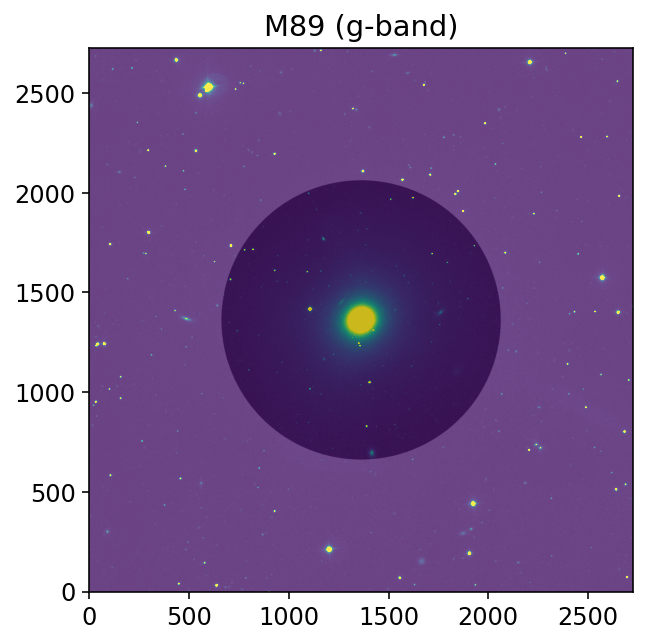

In [35]:
# fetch image
m89_g.set_image()

### 2. Aperture photometry of nearby stars

플럭스와 등급의 영점을 확인하고 PSF의 FWHM을 얻기 위해 구경측광을 수행한다.
PSF의 FWHM보다 작은 크기의 영역에서는 표면 밝기의 분포를 분해할 수 없기 때문에 추후에 표면 밝기 분포를 피팅할 때 FWHM 밖의 영역에서 피팅을 할 수 있도록 FWHM을 구하는 과정이 필요하다 (물론 눈으로 보고 피팅할 구간을 정해도 문제없지만, 누구나 납득할 수 있는 기준을 세우는 편이 주관적 효과를 최대한 배제할 수 있기 때문에 더 좋다).

구경측광에 사용된 천체는 SDSS에서 별로 분류된 측광 대상 중 16등급 이상의 clean photometry 조건을 만족하는 별을 사용하였고, 이는 SQL query를 통해 얻었다. (자세한 과정은 코드를 들여다 볼 것)

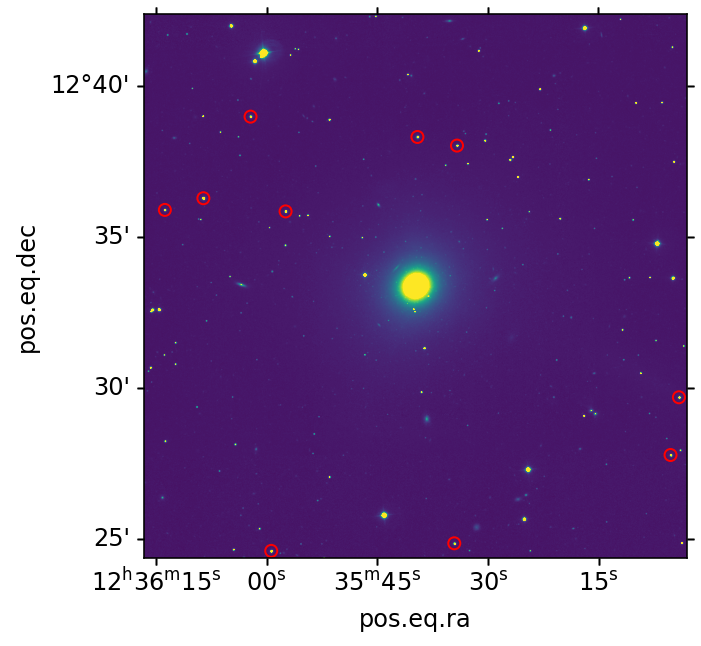

In [36]:
# query stars from SDSS to check the zeropoint
m89_g.set_ref_stars(maglimit=16.5, display=True)

위에서 구경측광을 위한 별을 총 10개 얻은 것을 확인할 수 있다. 이제 이 별들에 대해서 구경측광을 통해 등급의 영점(zero-point)와 PSF의 FWHM을 측정해보자.

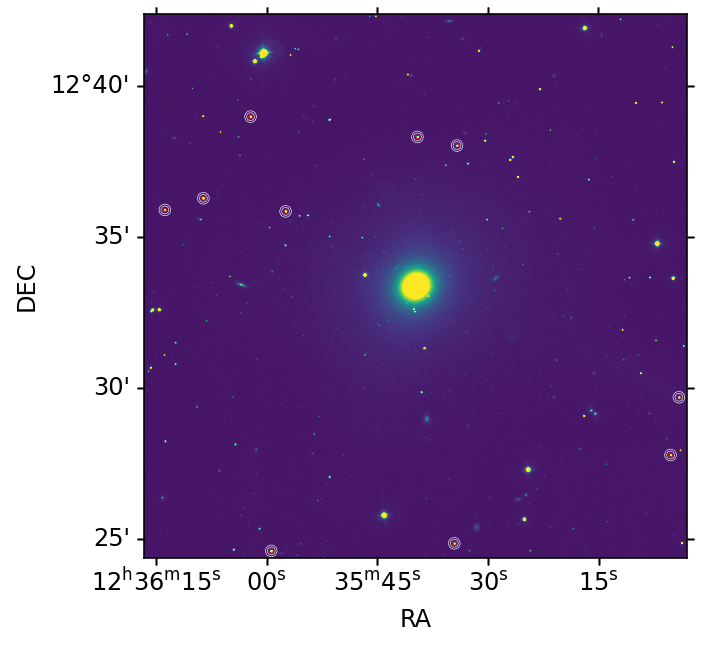

In [37]:
m89_g.apphot_stars()
mag0_from_apphot_g = m89_g.get_mag0()

In [38]:
mag0_from_apphot_g

<Column name='g' dtype='float64' length=10>
 22.48373169093535
 22.48019774053186
22.485236143880748
 22.49567704018198
22.466068876592708
 22.49037930569147
22.498645648103505
22.474196940933336
22.475719973739082
 22.48788409531987

위 결과를 보면 등급의 영점이 SDSS의 영점인 22.5에 가까운것을 확인할 수 있다. 평균은 다음과 같이 22.48을 얻었다.

In [39]:
print(np.mean(mag0_from_apphot_g))

22.48377374559099


### 3. Ellipse fitting

`photutils.isophotes.ellipse`에 사용되는 여러가지 keyword arguments를 설정해주고 (M89에 맞는 값을 기본값으로 택하였으니 코드 참고) 장반경(semi-major axis; sma)의 최솟값과 최댓값을 지정하여 타원 피팅을 한다. 이 작업에는 시간이 꽤 소요되니 염두에 둘 것 (피팅하는데 43초, 모델 이미지를 만드는데 약 7분).

Start: Mon May 16 13:39:10 2022
Elapsed time : 0.72 min (43.13 sec)
Elapsed time (Making model image) : 6.62 min (397.28 sec)


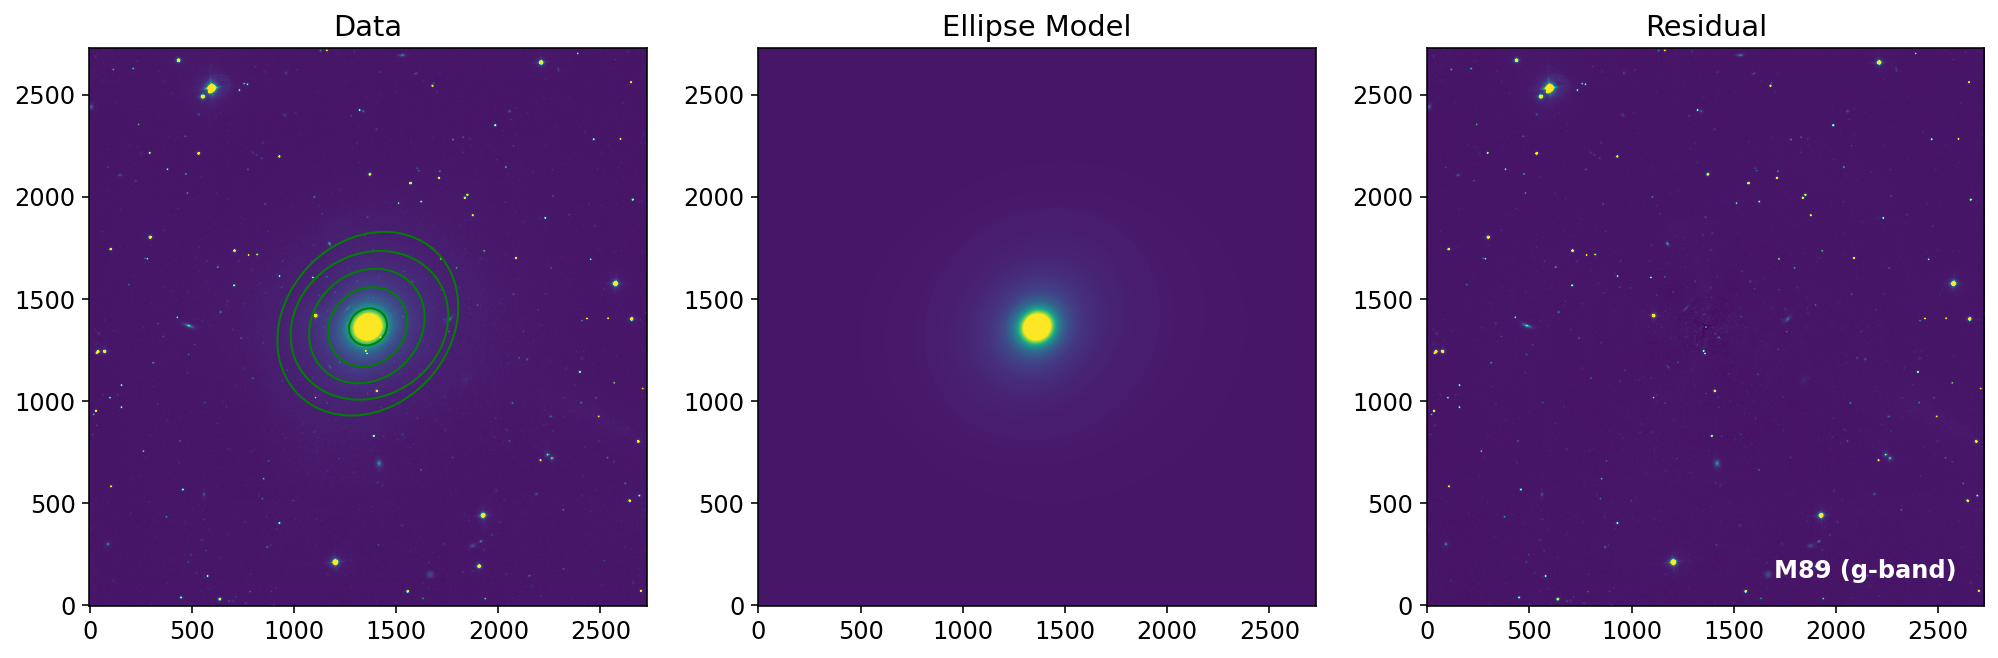

In [40]:
m89_g.set_kwargs_simple()  # set keyword arguments with default setting
                           # use set_kwargs function for custom kwargs.
m89_g.ellipse(minsma=0.1, maxsma=1000.)

### 4. Radial profile of surface brightness 

* de Vaucouleurs profile

$$I(R) = I_e \exp \left\{-7.669 \left(\frac{R}{R_e}\right)^{1/4}-1\right\}$$

* Sersic profile (Useful reference: [Graham & Driver 2005](https://ui.adsabs.harvard.edu/abs/2005PASA...22..118G/abstract))

$$I(R) = I_e \exp \left\{-b_n \left(\frac{R}{R_e}\right)^{1/n}-1\right\}$$
or
$$\mu(R)=\mu_{e}+\frac{2.5b_{n}}{\rm ln(10)}\left[(R/R_{e})^{1/n}-1\right]$$

where $b_{n}=2n-1/3$, n is called the Sersic index.

일반적으로 타원은하의 표면 밝기 분포는 $n\sim4$ (de Vaucouleurs profile)를 따르고, 나선은하의 표면 밝기 분포는 $n\sim1$ (exponential profile)을 따른다.

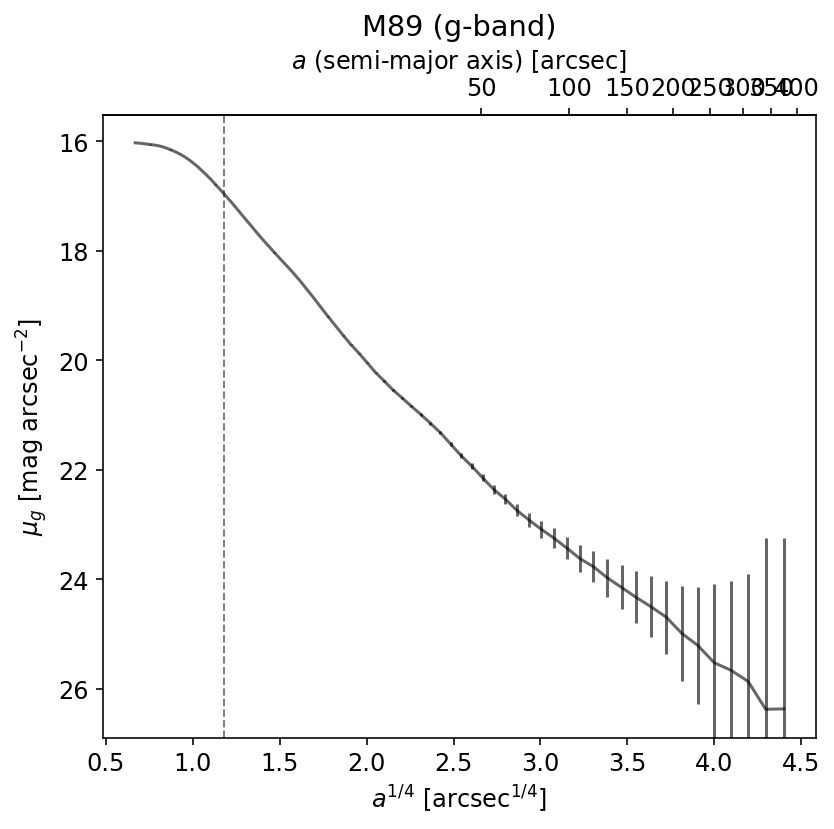

In [41]:
m89_g.set_radial_profile()

Sersic profile으로 피팅해서 Sersic index가 어느정도인지 구해보자.

<AxesSubplot:title={'center':'M89 (g-band)'}, xlabel='$a^{1/4}$ [arcsec$^{1/4}$]', ylabel='$\\mu_g$ [mag ${\\rm arcsec^{-2}}$]'>

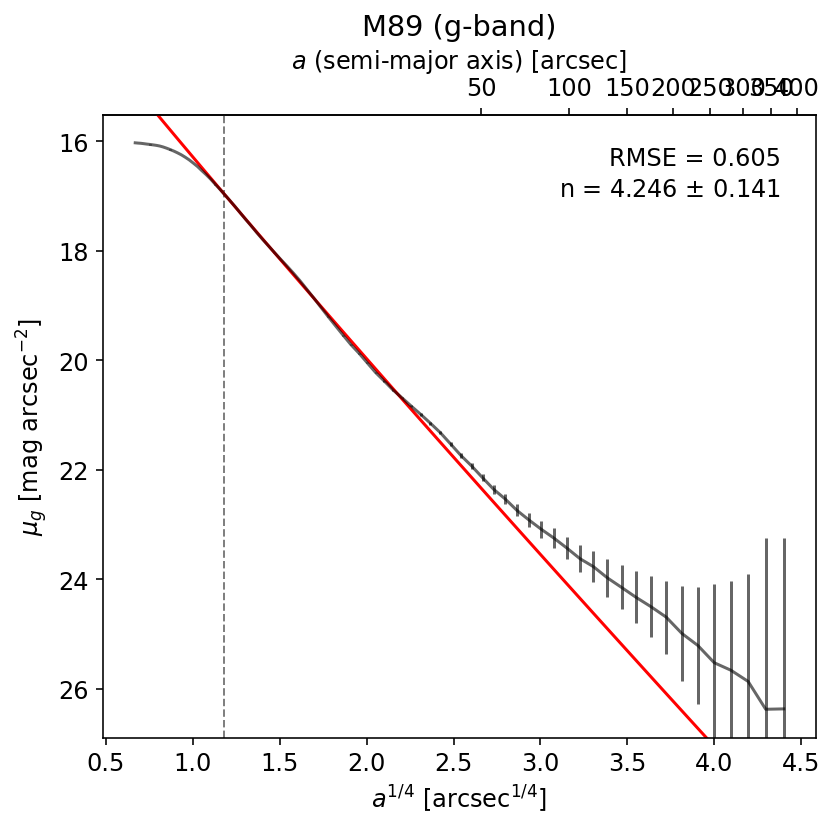

In [42]:
m89_g.fit_radial_profile(double=False)
m89_g.display_radial_profile()

$n = 4.246 \pm 0.141$로 M89가 g밴드에서 타원은하의 일반적인 표면밝기 분포를 가지는 것을 확인할 수 있다.

### 5. Same procedure for r-band

Image: m89_r
sky level: 0.0041
sky sigma: 0.0202
estimated magnitude zeropoint: 22.482963144546595
Start: Sun May 15 22:23:30 2022
Elapsed time : 0.66 min (39.75 sec)
Elapsed time (Making model image) : 6.64 min (398.26 sec)


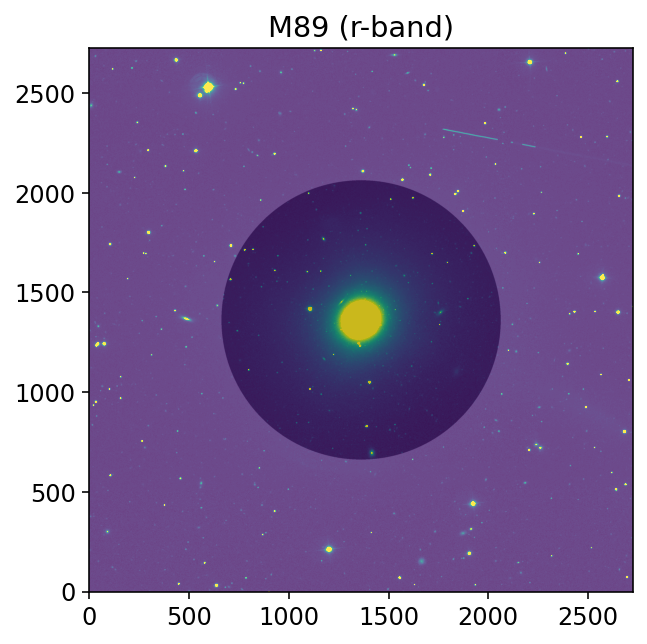

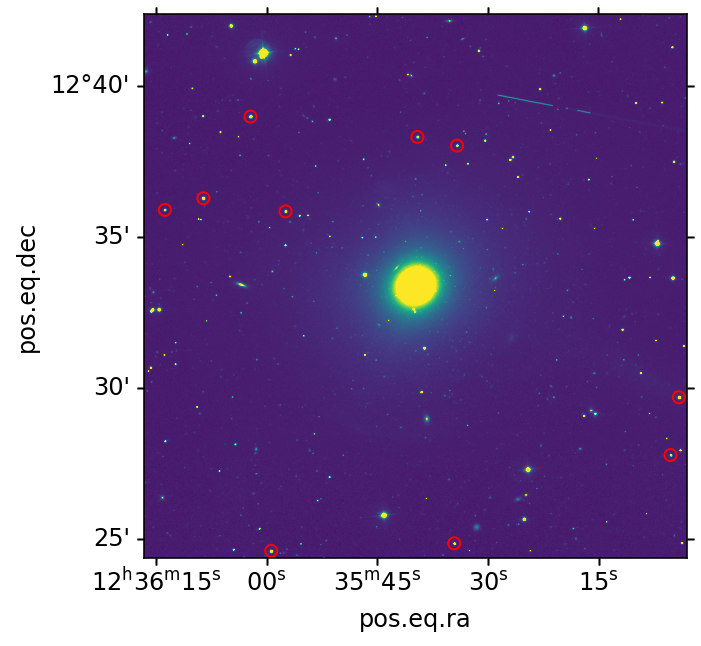

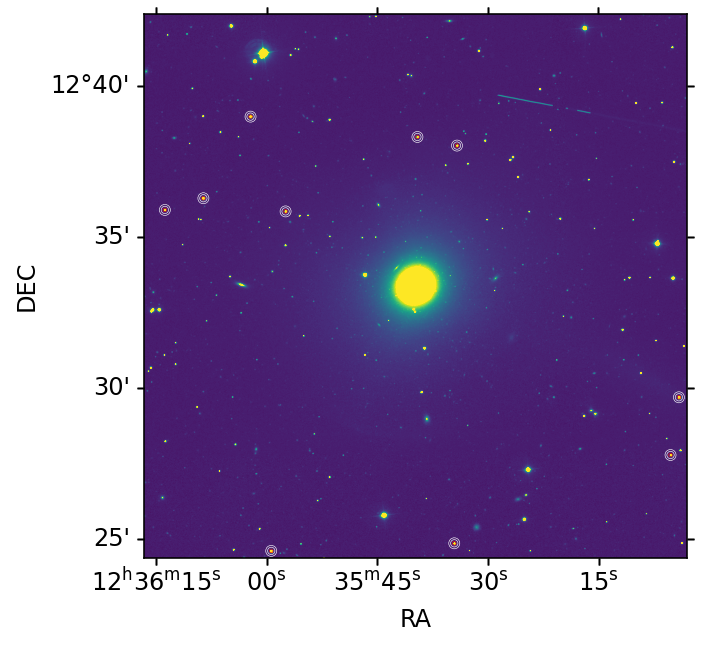

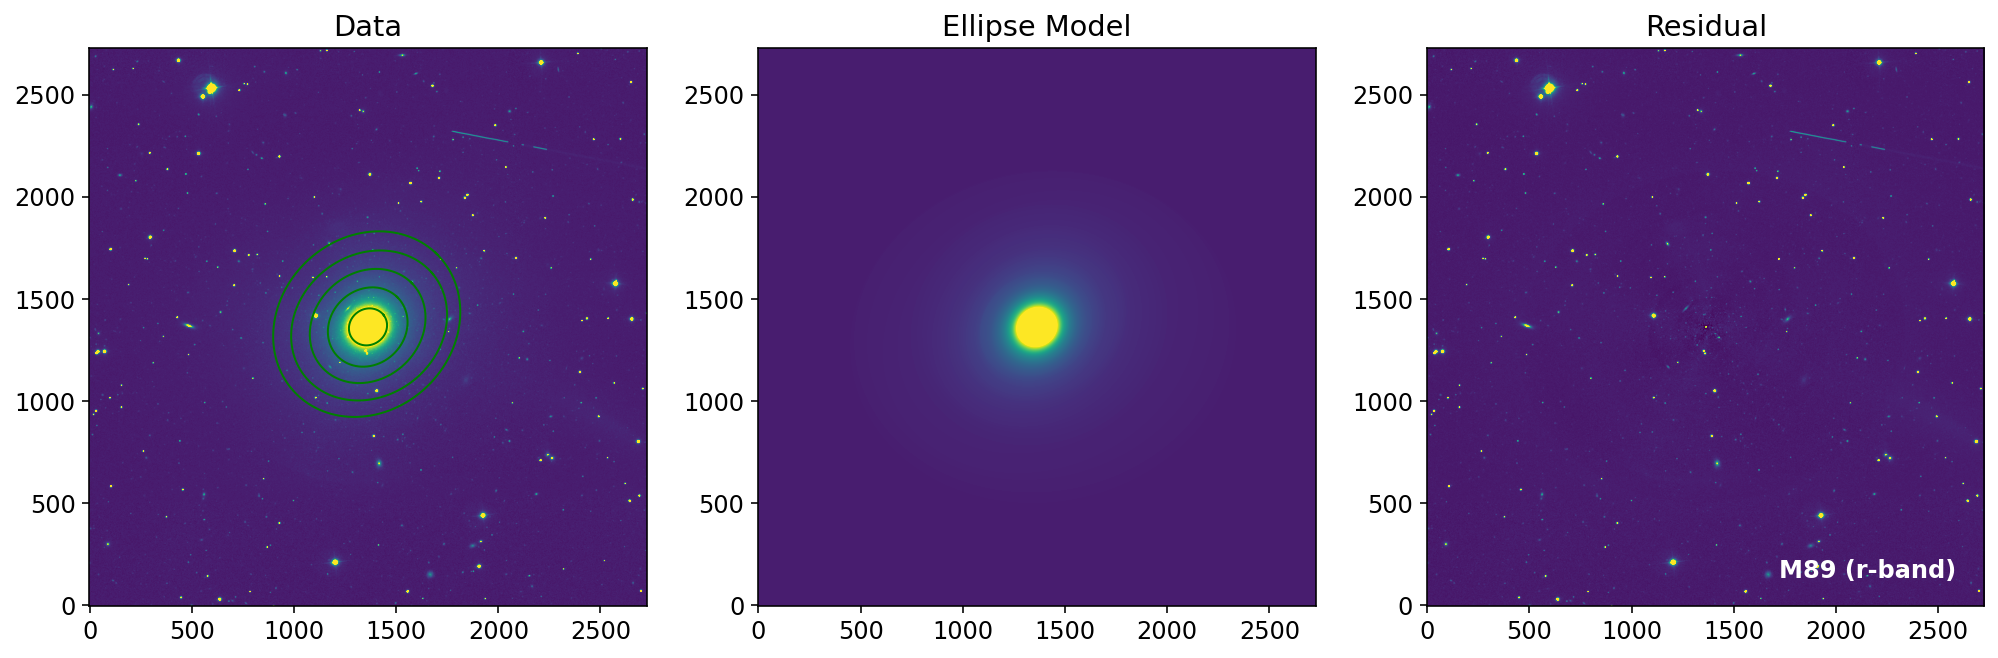

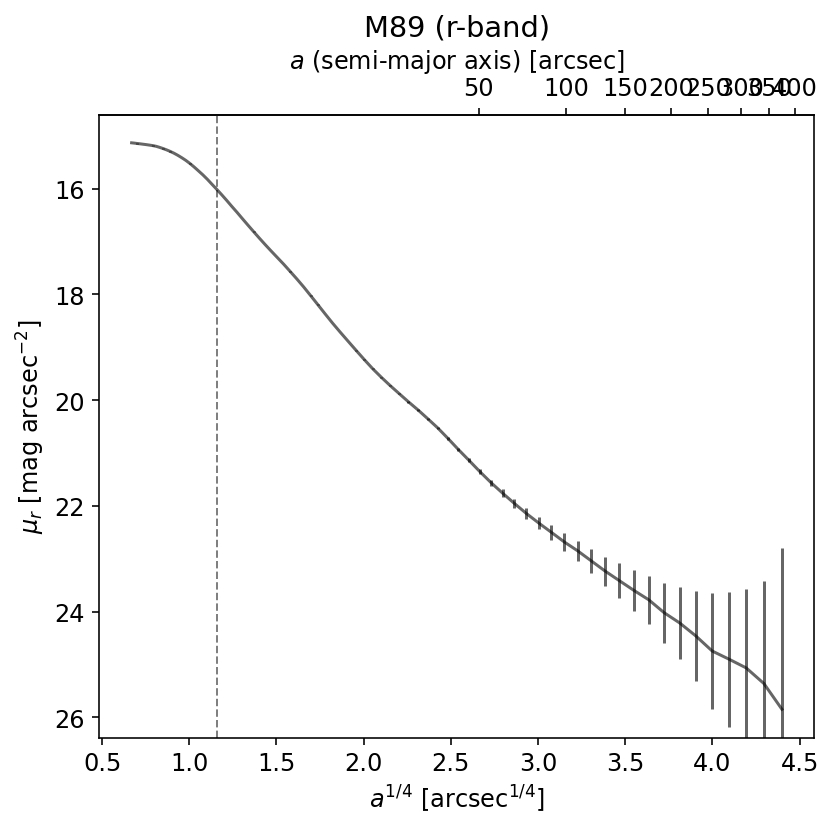

In [18]:
# let's do ellipse photometry for other images
m89_r = SloanGalaxySurfacePhot(imglist[1], 700, pixel_scale, 'M89', 'r')

m89_r.set_image()
m89_r.set_ref_stars(maglimit=16.5, display=True)
m89_r.apphot_stars()
print('estimated magnitude zeropoint:', np.mean(m89_r.get_mag0()))
m89_r.set_kwargs_simple()
m89_r.ellipse(minsma=0.1, maxsma=1000.)
m89_r.set_radial_profile()
m89_r.fit_radial_profile(double=False)

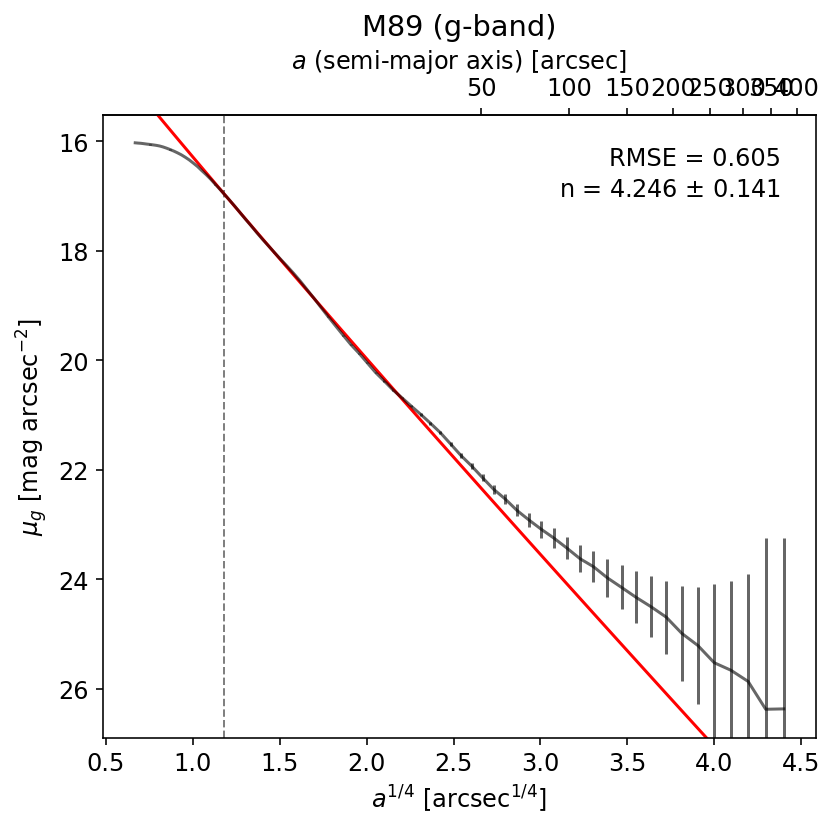

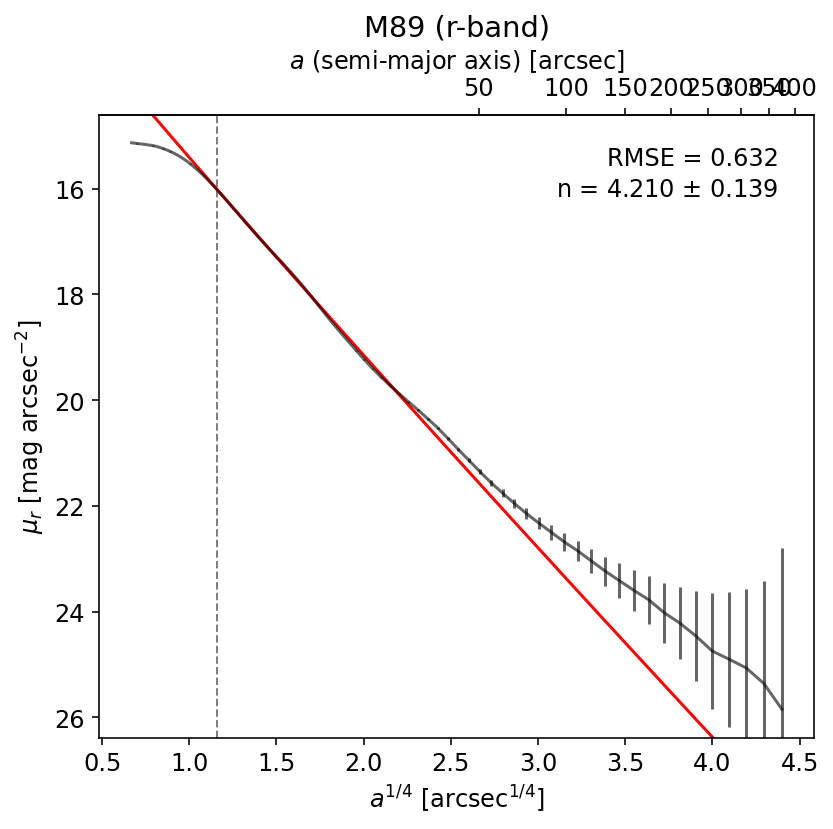

In [20]:
for sgsp in [m89_g, m89_r]:
    sgsp.display_radial_profile()

### 6. Color profile

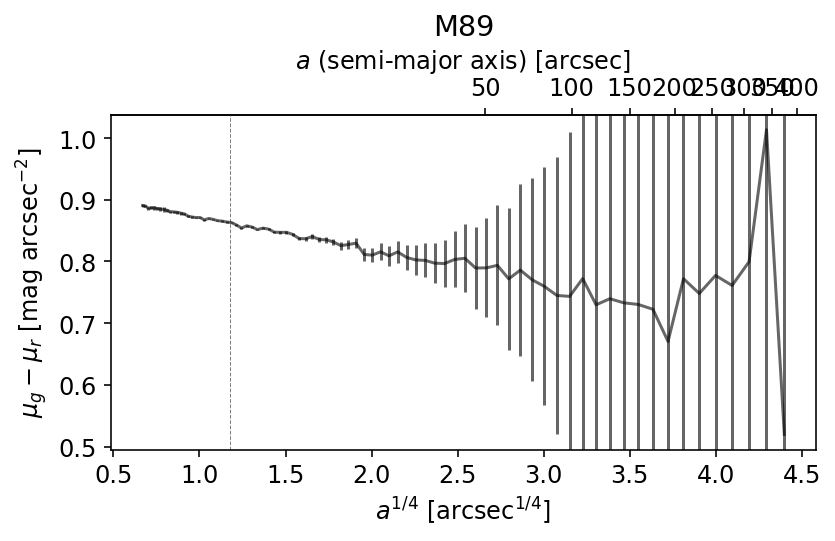

In [21]:
# color profile
display_color_profile(m89_g, m89_r, 'M89')

### 7. Radial profiles of other geometrical properties

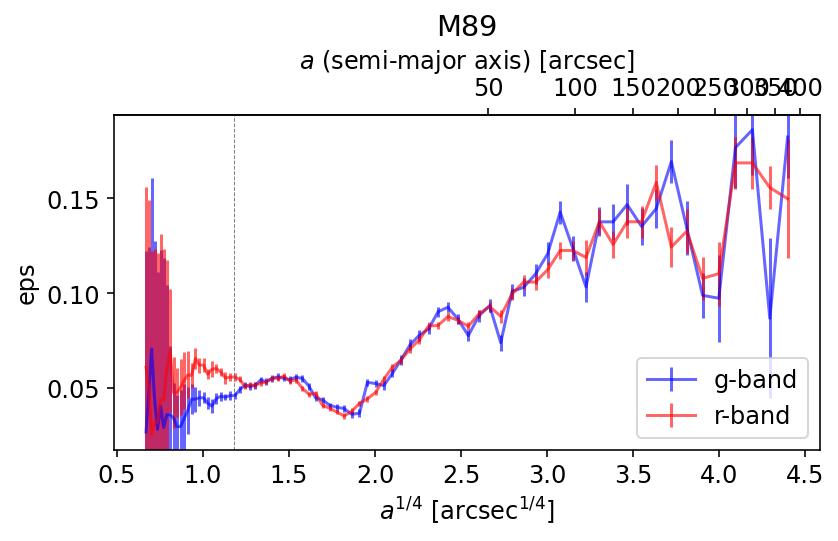

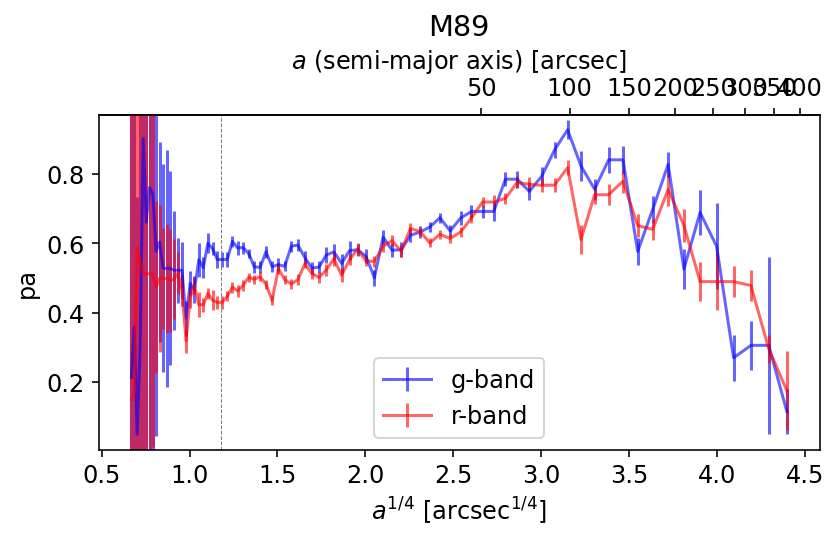

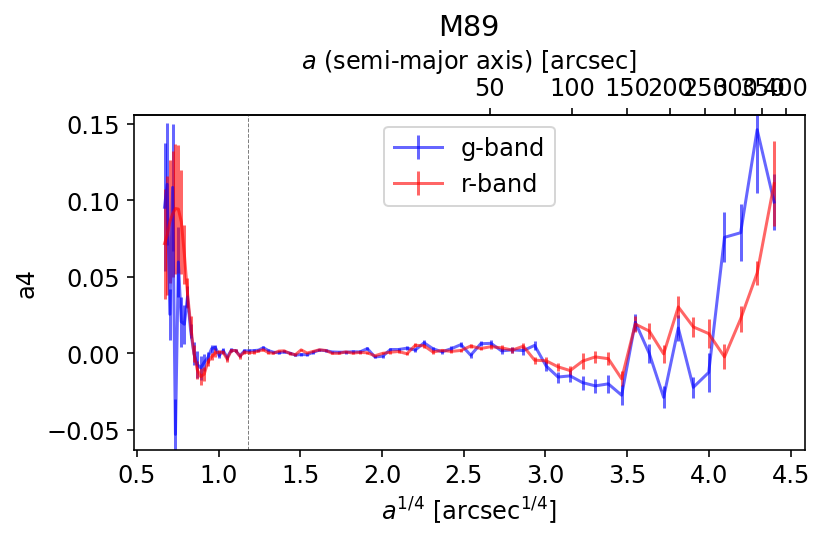

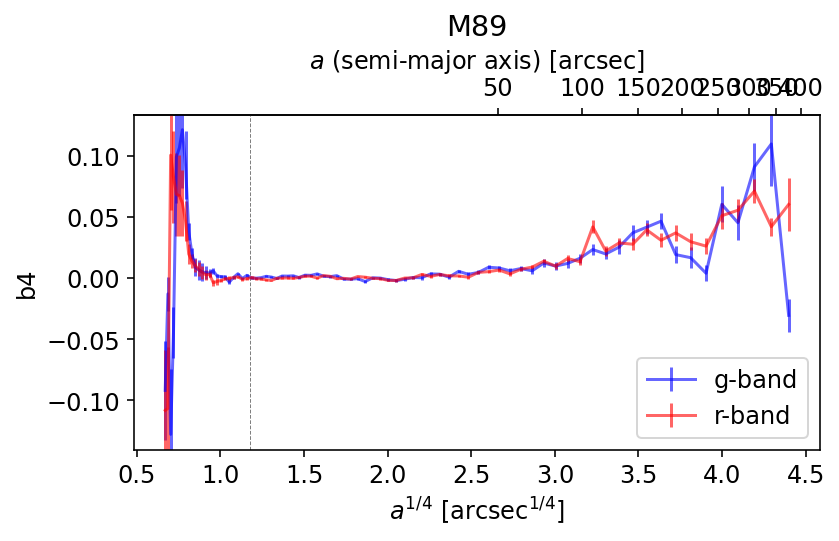

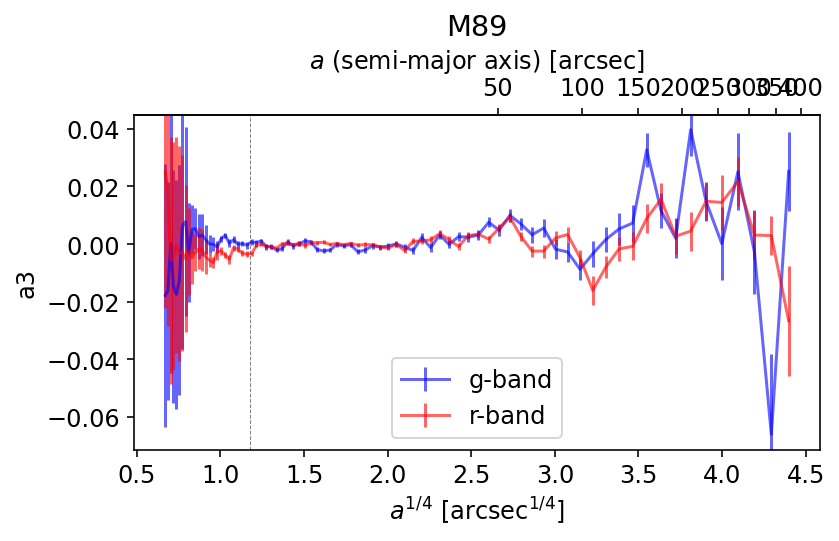

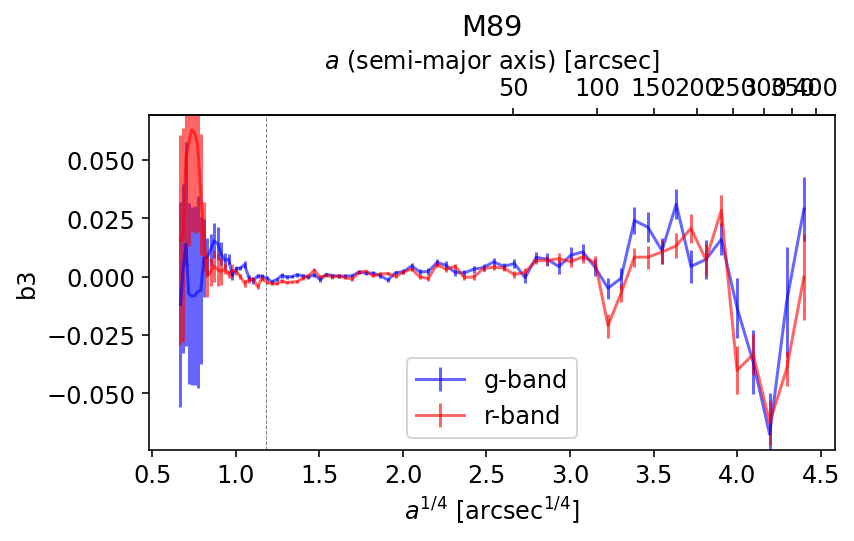

In [24]:
# profiles of various structure properties
for prop in ['eps', 'pa', 'a4', 'b4', 'a3', 'b3']:
    display_profile_prop(prop, m89_g, m89_r, 'M89')

### 8. Total magnitude

총 등급은 장반경의 최댓값으로 설정해 준 값 이내의 플럭스를 모두 더해 구한 등급을 말하며, 다음과 같이 계산할 수 있다. 오차를 계산할 때 배경의 오차를 고려해야 하지만 다른 오차에 비해 그 값이 상당히 작아 무시하였다.

In [29]:
for sgsp in [m89_g, m89_r]:
    tflux = sgsp.isolist.tflux_e[-1]
    mag = sgsp.flux2mag(tflux)
    mag_err = 2.5*np.sqrt(tflux)/tflux/np.log(10)
    # npix_e = sgsp.isolist.npix_e[-1]
    # mag_err = 2.5*np.sqrt(tflux+npix_e*sgsp.sky_sig**2)/tflux/np.log(10)
    print(f'$ {sgsp.band} = {mag:.3f} \pm {mag_err:.3f} $')

$ g = 10.081 \pm 0.004 $
$ r = 9.284 \pm 0.002 $


따라서 타원 피팅을 통한 모델링으로 얻은 M89의 총 등급은 다음과 같다.
$$ g = 10.081 \pm 0.004 $$

$$ r = 9.284 \pm 0.002 $$

하지만 SIMBAD의 정리된 M89의 등급은 $g = 11.270\pm0.001$, $r=10.438\pm0.001$으로 g밴드와 r밴드 모두 1등급 이상의 systematic error를 보인다. 왜일까? 궁금하다면 [Abazajian et al. 2009의 5절](https://iopscience.iop.org/article/10.1088/0067-0049/182/2/543)에 그 해답이 있다.